<a href="https://colab.research.google.com/github/vimesh630/ML_CW/blob/main/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries and Mount Google Drive

In [1]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Preprocess Data

In [3]:
# Load preprocessed data
train_data_path = '/content/drive/My Drive/ML Coursework/Preprocessed Dataset/X_train.csv'
test_data_path = '/content/drive/My Drive/ML Coursework/Preprocessed Dataset/X_test.csv'

y_train_path = '/content/drive/My Drive/ML Coursework/Preprocessed Dataset/y_train.csv'
y_test_path = '/content/drive/My Drive/ML Coursework/Preprocessed Dataset/y_test.csv'

# Load data
X_train = pd.read_csv(train_data_path).values
X_test = pd.read_csv(test_data_path).values
y_train = pd.read_csv(y_train_path).values.ravel()
y_test = pd.read_csv(y_test_path).values.ravel()

Define and Train the Random Forest Model

In [10]:
# Define and train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=300,          # Increased number of trees
    max_depth=20,              # Deeper trees
    min_samples_split=5,       # Minimum samples to split a node
    min_samples_leaf=2,        # Minimum samples for a leaf
    max_features='sqrt',       # Use square root of features
    class_weight='balanced',   # Handle class imbalance
    random_state=42            # Reproducibility
)
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300, random_state=42)

Evaluate the Model

In [11]:
# Predict on test data
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate accuracy metrics
train_accuracy = rf_model.score(X_train, y_train)  # Training accuracy
test_accuracy = accuracy_score(y_test, y_pred)     # Test accuracy
roc_auc = roc_auc_score(y_test, y_pred_proba)      # ROC-AUC score

# Print accuracy values
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Training Accuracy: 0.9788
Test Accuracy: 0.9521
ROC-AUC Score: 0.9923

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      8015
           1       0.93      0.98      0.95      8072

    accuracy                           0.95     16087
   macro avg       0.95      0.95      0.95     16087
weighted avg       0.95      0.95      0.95     16087



# Visualiations

Confusion Matrix

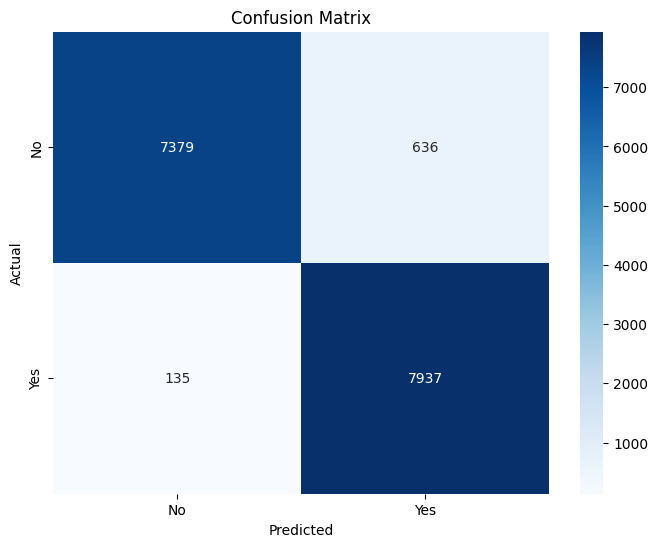

In [12]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Feature Importance

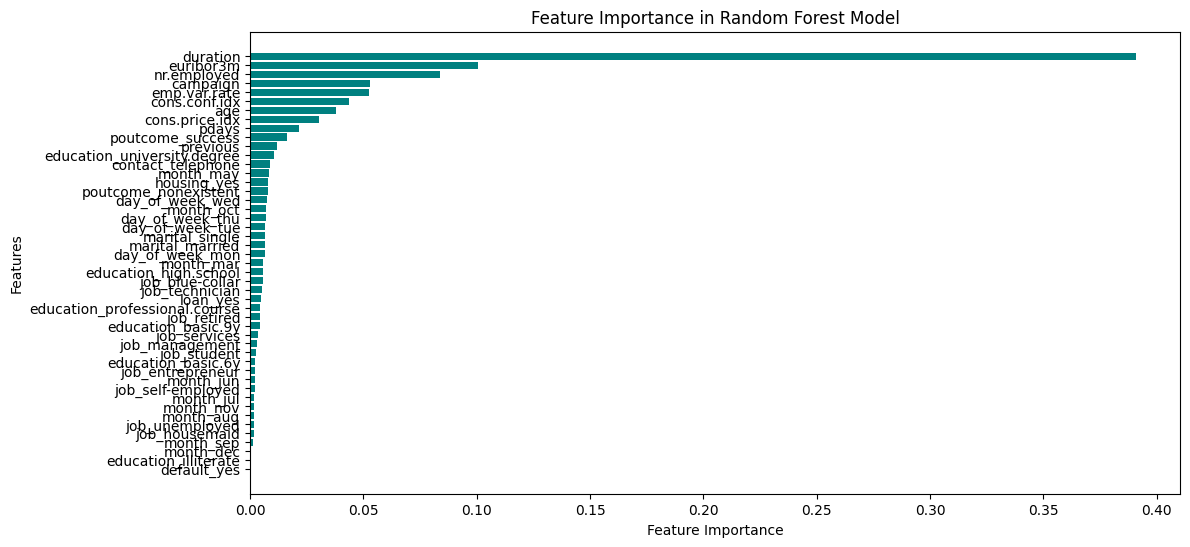

In [13]:
feature_importances = rf_model.feature_importances_
feature_names = pd.read_csv(train_data_path).columns
plt.figure(figsize=(12, 6))
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)
plt.barh(importance_df["Feature"], importance_df["Importance"], color='teal')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

ROC Curve

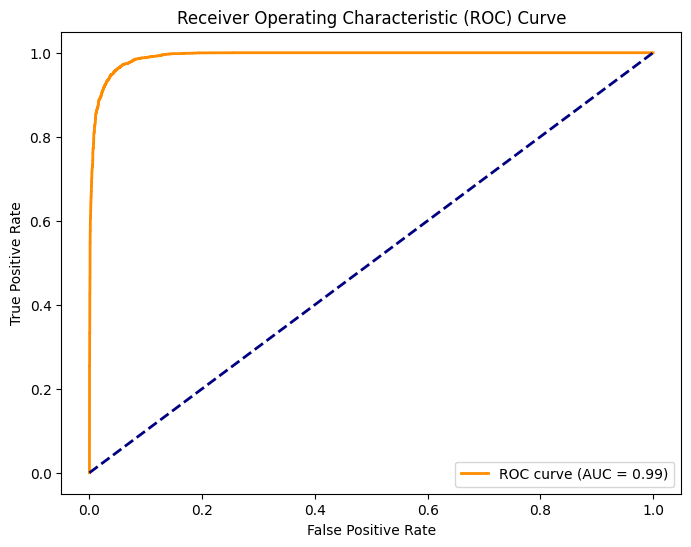

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Predictions for Sample Clients

In [15]:
# Predict probabilities and classes for sample clients
sample_clients = X_test[:10]
predicted_probabilities = rf_model.predict_proba(sample_clients)[:, 1]  # Probabilities for class "1" (Yes)
predicted_classes = rf_model.predict(sample_clients)  # Binary predictions

# Print the results
print("Predicted Probabilities for 'Yes':\n", predicted_probabilities)
print("Predicted Classes (0 = No, 1 = Yes):\n", predicted_classes)

Predicted Probabilities for 'Yes':
 [0.01403724 0.23950289 0.93242002 0.96955608 0.0128404  0.86572075
 0.89546863 0.87326347 0.01759843 0.19749594]
Predicted Classes (0 = No, 1 = Yes):
 [0 0 1 1 0 1 1 1 0 0]
